<a href="https://colab.research.google.com/github/VictorPetrochenkov/skillfactory_rds/blob/master/SF_mod_9_GAN_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install -q tensorflow==2.1

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

print(tf.__version__)

2.8.2


In [6]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [7]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-9126124f-f777-cee2-386b-fc56f9d3526a)


## Load and preprocess MNIST dataset

In [8]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = (train_x.reshape(-1, 28*28).astype(np.float32) - 127.5) / 127.5

print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

11501568/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
-1.0 1.0


## Draw MNIST examples

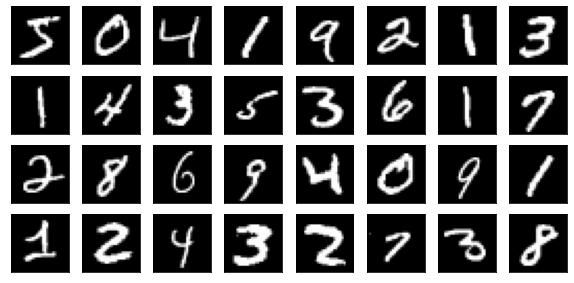

In [9]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Create GAN parts: Generator and Discriminator

In [10]:
generator = M.Sequential([
    L.Dense(256),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(512),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(1024),
    L.LeakyReLU(0.2),
    L.BatchNormalization(momentum=0.8),
    L.Dense(784, activation='tanh'),
])

discriminator = M.Sequential([
    L.Dense(784, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(392, activation=None),
    L.LeakyReLU(alpha=0.2),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [11]:
INPUT_DIM = 100
NUM_EPOCHS = 5
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## GAN training

[Step  0] D Loss: 0.9471; G Loss: 0.7359


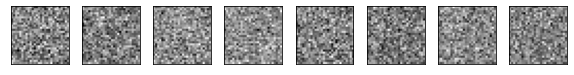

[Step 500] D Loss: 0.2489; G Loss: 7.3690


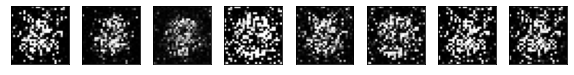

[Step 1000] D Loss: 0.3522; G Loss: 3.1855


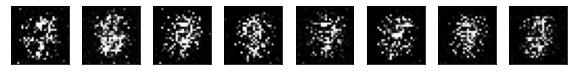

[Step 1500] D Loss: 0.2820; G Loss: 2.7840


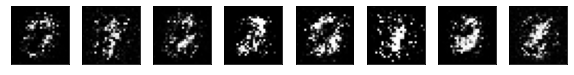

[Step 2000] D Loss: 0.3098; G Loss: 2.7132


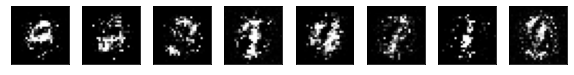

[Step 2500] D Loss: 0.3919; G Loss: 2.5487


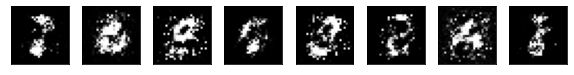

[Step 3000] D Loss: 0.5225; G Loss: 1.1109


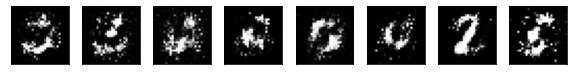

[Step 3500] D Loss: 0.5302; G Loss: 1.5213


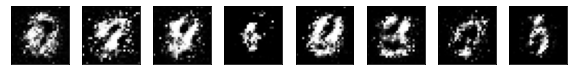

[Step 4000] D Loss: 0.5975; G Loss: 1.2749


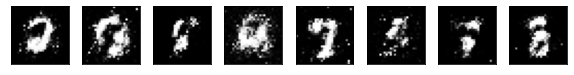

[Step 4500] D Loss: 0.7121; G Loss: 0.7361


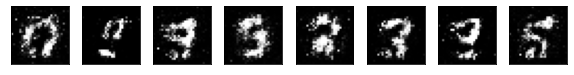

[Step 5000] D Loss: 0.5757; G Loss: 1.8464


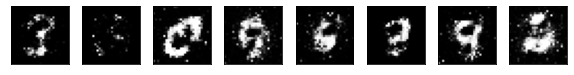

[Step 5500] D Loss: 0.4598; G Loss: 0.8203


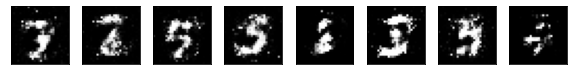

[Step 6000] D Loss: 0.4348; G Loss: 1.7097


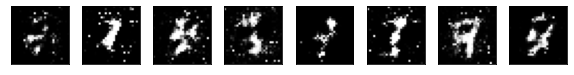

[Step 6500] D Loss: 0.5322; G Loss: 0.7261


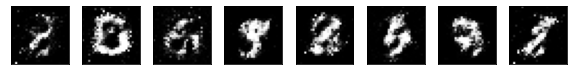

[Step 7000] D Loss: 0.9473; G Loss: 1.6494


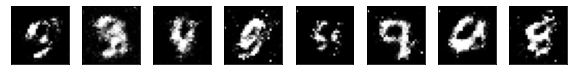

[Step 7500] D Loss: 0.4391; G Loss: 1.3703


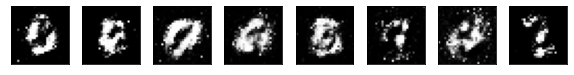

[Step 8000] D Loss: 0.5394; G Loss: 2.1721


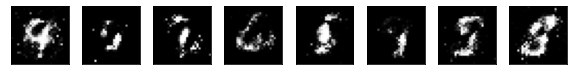

[Step 8500] D Loss: 0.5970; G Loss: 1.2499


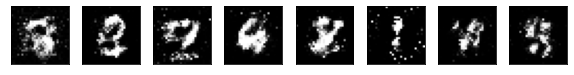

[Step 9000] D Loss: 0.5981; G Loss: 1.5528


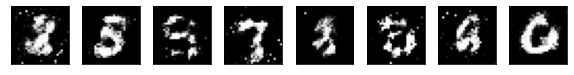

[Step 9500] D Loss: 0.4075; G Loss: 2.0910


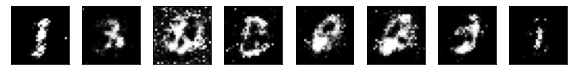

[Step 10000] D Loss: 0.6562; G Loss: 1.3498


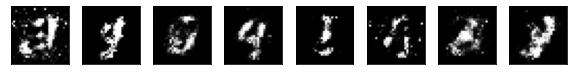

[Step 10500] D Loss: 0.7314; G Loss: 1.2008


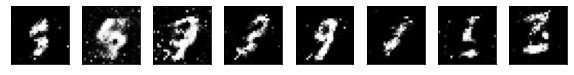

[Step 11000] D Loss: 0.6348; G Loss: 1.0656


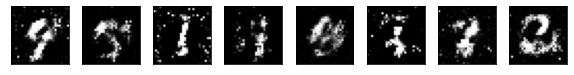

[Step 11500] D Loss: 0.5699; G Loss: 0.9611


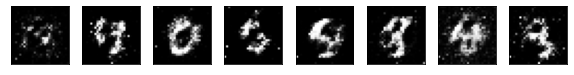

[Step 12000] D Loss: 0.4666; G Loss: 1.2423


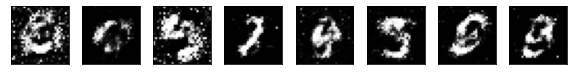

[Step 12500] D Loss: 0.4347; G Loss: 0.8031


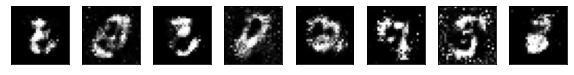

[Step 13000] D Loss: 0.5131; G Loss: 0.7394


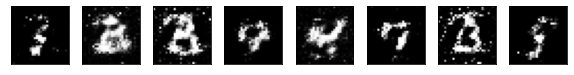

[Step 13500] D Loss: 0.6059; G Loss: 0.6845


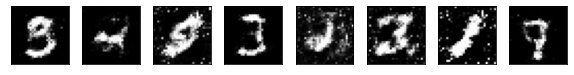

[Step 14000] D Loss: 0.6164; G Loss: 0.7684


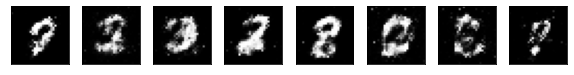

[Step 14500] D Loss: 0.5600; G Loss: 1.4912


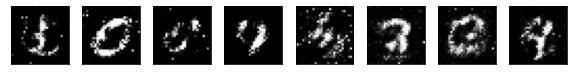

[Step 15000] D Loss: 0.5483; G Loss: 1.4832


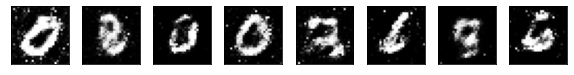

[Step 15500] D Loss: 0.5159; G Loss: 1.0529


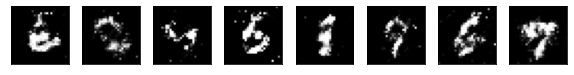

[Step 16000] D Loss: 0.5754; G Loss: 1.5984


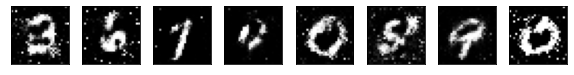

[Step 16500] D Loss: 0.6418; G Loss: 0.5853


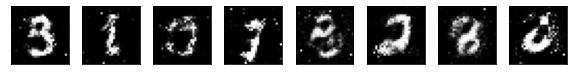

[Step 17000] D Loss: 0.4470; G Loss: 1.6471


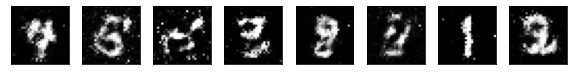

[Step 17500] D Loss: 0.5595; G Loss: 1.6757


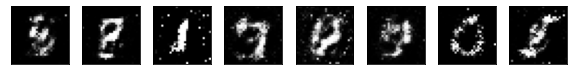

[Step 18000] D Loss: 0.5018; G Loss: 1.1655


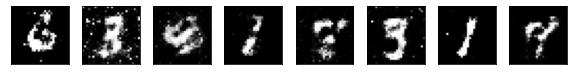

[Step 18500] D Loss: 0.5371; G Loss: 1.3195


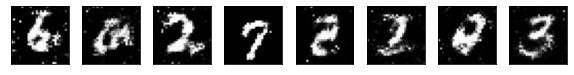

In [12]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

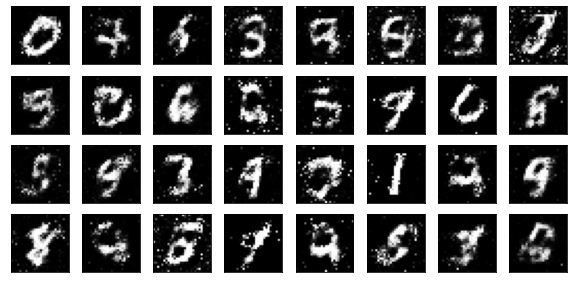

In [13]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

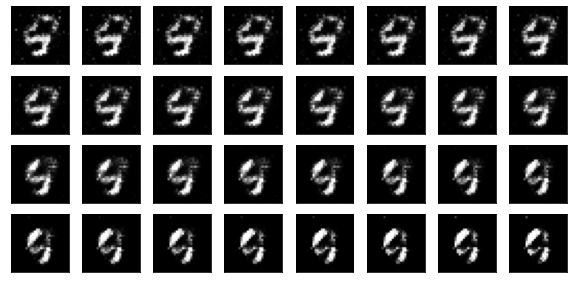

In [14]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Deep Convolutional GAN (DCGAN)

In [15]:
generator = M.Sequential([
    L.Dense(128*7*7, activation="relu"),
    L.Reshape((7, 7, 128)),
    L.UpSampling2D((2, 2)),    
    L.Conv2D(128, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.UpSampling2D((2, 2)),    
    L.Conv2D(64, (3, 3), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.ReLU(),    
    L.Conv2D(1, (3, 3), padding="same", activation='tanh'),
])

discriminator = M.Sequential([
    L.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
    L.LeakyReLU(0.2),
    L.Dropout(0.25),    
    L.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same"),
    L.ZeroPadding2D(padding=((0, 1), (0, 1))),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(128, kernel_size=3, strides=(2, 2), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Conv2D(256, kernel_size=3, strides=(1, 1), padding="same"),
    L.BatchNormalization(momentum=0.8),
    L.LeakyReLU(alpha=0.2),
    L.Dropout(0.25),
    L.Flatten(),
    L.Dense(1, activation=None),
])

## Training parameters, dataset pipeline, optimizer

In [16]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 28, 28, 1))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## DCGAN training

[Step  0] D Loss: 0.6200; G Loss: 0.6493


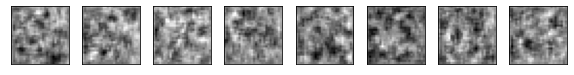

[Step 200] D Loss: 0.8071; G Loss: 3.4193


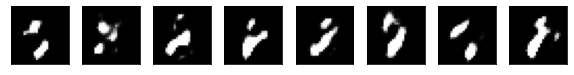

[Step 400] D Loss: 0.6596; G Loss: 2.2246


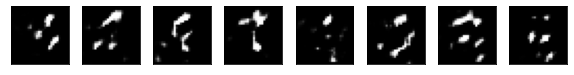

[Step 600] D Loss: 0.6952; G Loss: 0.9690


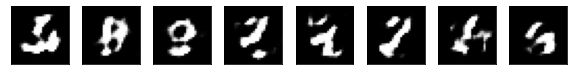

[Step 800] D Loss: 0.6659; G Loss: 1.1479


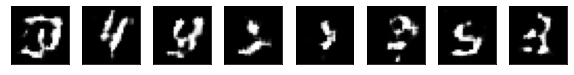

[Step 1000] D Loss: 0.6647; G Loss: 0.9196


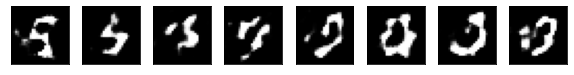

[Step 1200] D Loss: 0.6753; G Loss: 0.8908


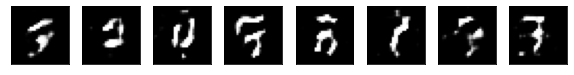

[Step 1400] D Loss: 0.8047; G Loss: 0.8960


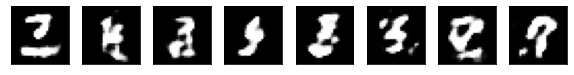

[Step 1600] D Loss: 0.6562; G Loss: 1.2209


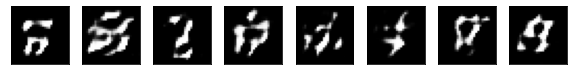

[Step 1800] D Loss: 0.7950; G Loss: 1.1982


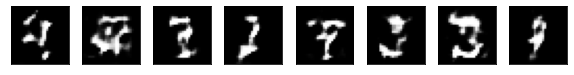

[Step 2000] D Loss: 0.6323; G Loss: 1.0672


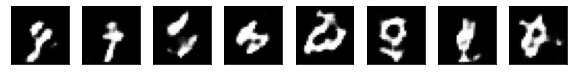

[Step 2200] D Loss: 0.7540; G Loss: 0.7722


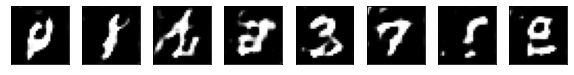

[Step 2400] D Loss: 0.7333; G Loss: 0.8587


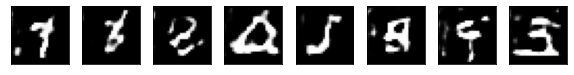

[Step 2600] D Loss: 0.6548; G Loss: 0.9460


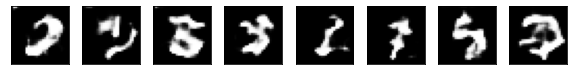

[Step 2800] D Loss: 0.5622; G Loss: 1.0132


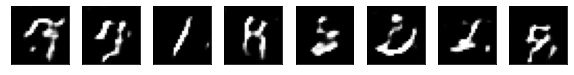

[Step 3000] D Loss: 0.6992; G Loss: 0.9579


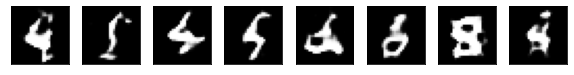

[Step 3200] D Loss: 0.6892; G Loss: 1.1231


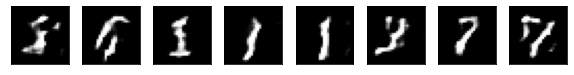

[Step 3400] D Loss: 0.6706; G Loss: 0.9998


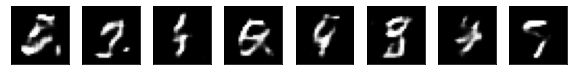

[Step 3600] D Loss: 0.7243; G Loss: 0.8310


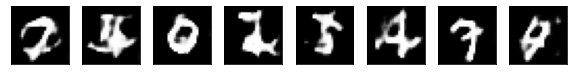

[Step 3800] D Loss: 0.7290; G Loss: 0.8750


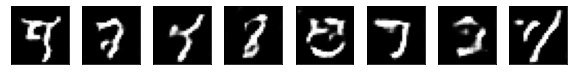

[Step 4000] D Loss: 0.6897; G Loss: 1.0038


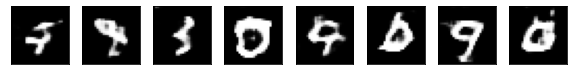

[Step 4200] D Loss: 0.6916; G Loss: 0.8335


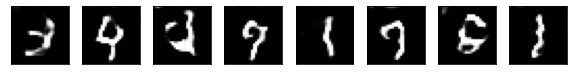

[Step 4400] D Loss: 0.7553; G Loss: 0.6971


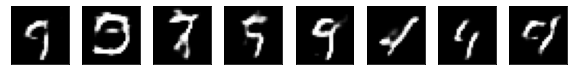

[Step 4600] D Loss: 0.6034; G Loss: 1.0692


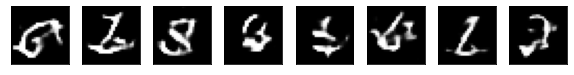

[Step 4800] D Loss: 0.6457; G Loss: 0.9557


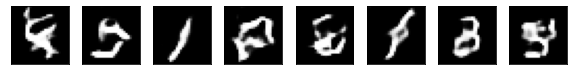

[Step 5000] D Loss: 0.8411; G Loss: 0.9193


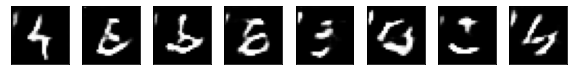

[Step 5200] D Loss: 0.5831; G Loss: 1.1882


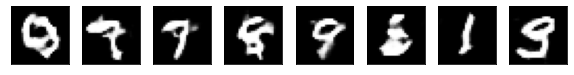

[Step 5400] D Loss: 0.8556; G Loss: 0.6694


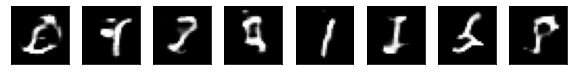

[Step 5600] D Loss: 0.8022; G Loss: 0.7965


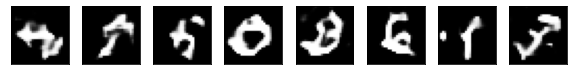

[Step 5800] D Loss: 0.6783; G Loss: 1.0132


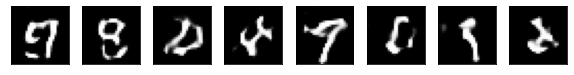

[Step 6000] D Loss: 0.6458; G Loss: 0.7712


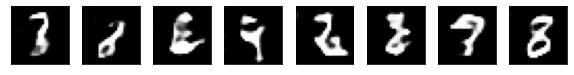

[Step 6200] D Loss: 0.6930; G Loss: 0.7647


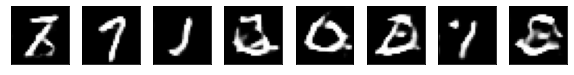

[Step 6400] D Loss: 0.6707; G Loss: 0.8213


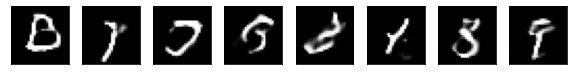

[Step 6600] D Loss: 0.6665; G Loss: 0.7333


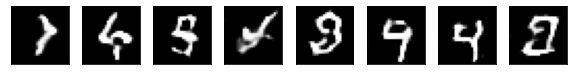

[Step 6800] D Loss: 0.7657; G Loss: 0.8296


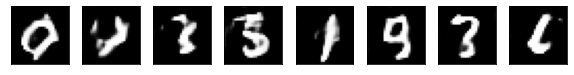

[Step 7000] D Loss: 0.7116; G Loss: 0.8607


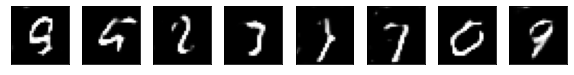

[Step 7200] D Loss: 0.7040; G Loss: 0.7500


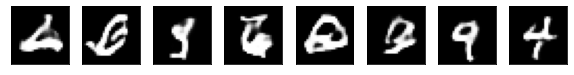

[Step 7400] D Loss: 0.6632; G Loss: 0.7475


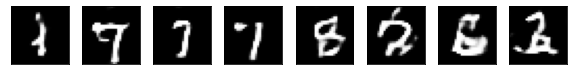

In [17]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1)), 
        np.zeros((HALF_BATCH_SIZE, 1))))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1))
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = tf.compat.v1.losses.sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print("[Step %2d] D Loss: %.4f; G Loss: %.4f" % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Generator test: random examples

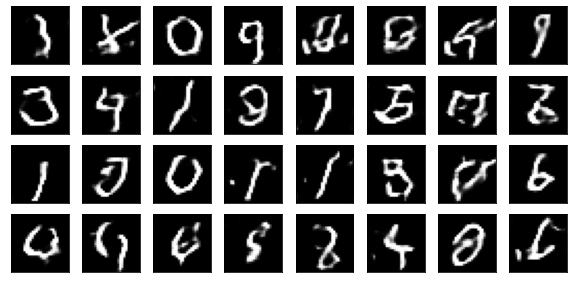

In [ ]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Generator test: continuous examples

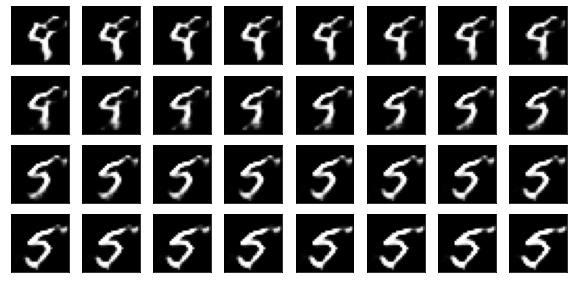

In [ ]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

In [ ]:
# больше примеров можно найти тут https://github.com/eriklindernoren/Keras-GAN